In [1]:
!pip install -e ..

Obtaining file:///export/home/fornax/jhoskins/Development/astrohack
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for astrohack (pyproject.toml) ... done
  Created wheel for astrohack: filename=astrohack-0.0.1-py3-none-any.whl size=1052 sha256=a0dfcf04762da4eaca02f7c5a63dd8a41561b1bd664405f288d01df397757744
  Stored in directory: /tmp/pip-ephem-wheel-cache-ykx4ajzr/wheels/92/c4/f7/67427f82ce804bcc66fc63663cafee2be9a98c9f78ddf37022
Successfully built astrohack
  Attempting uninstall: astrohack
    Found existing installation: astrohack 0.0.1
    Uninstalling astrohack-0.0.1:
      Successfully uninstalled astrohack-0.0.1


In [2]:
import os
import tarfile
import shutil
import dask
import requests
import time
import psutil

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from astrohack import holog
from astrohack.dio import extract_holog
from astrohack.dio import load_hack_file
from astrohack._utils._io import _make_ant_pnt_dict

from dask.distributed import Client, LocalCluster

plt.rcParams["figure.figsize"] = (15, 15)

In [ ]:
holog(hack_file='hack_file.holog.zarr', padding_factor=10, parallel=False)

[2023-01-20 11:56:07.909098 System Info]: Loading holography file hack_file.holog.zarr ...
[2023-01-20 11:56:09.338625 System Info]: [_holog_chunk] FFT padding factor 10
[2023-01-20 11:56:09.338746 System Info]: Calculating aperture illumination pattern ...
[2023-01-20 11:56:10.798049 System Info]: [_holog_chunk] FFT padding factor 10
[2023-01-20 11:56:10.798171 System Info]: Calculating aperture illumination pattern ...
[2023-01-20 11:56:12.259589 System Info]: [_holog_chunk] FFT padding factor 10
[2023-01-20 11:56:12.259696 System Info]: Calculating aperture illumination pattern ...
[2023-01-20 11:56:13.722537 System Info]: [_holog_chunk] FFT padding factor 10
[2023-01-20 11:56:13.722649 System Info]: Calculating aperture illumination pattern ...
[2023-01-20 11:56:15.059225 System Info]: [_holog_chunk] FFT padding factor 10
[2023-01-20 11:56:15.059341 System Info]: Calculating aperture illumination pattern ...
[2023-01-20 11:56:16.394336 System Info]: [_holog_chunk] FFT padding facto

In [4]:
def performance(func):
    def wrapper(*args, **kwargs):
        start = time.time()
        func(*args, **kwargs)
        stop = time.time()
        print("Completion time: {}".format(stop - start))
    return wrapper

def _open_holog(hack_file, ddi):   
    ant_grid_data = {}
    
    ant_list =  [dir_name for dir_name in os.listdir(hack_file) if os.path.isdir(hack_file)]
    for ant in ant_list:
        ant_grid_data[int(ant)] = xr.open_zarr("{name}/{ant}/{ddi}".format(name=hack_file, ant=ant, ddi=ddi) )
        
    return ant_grid_data

def print_hack_file(hack):
    for ddi in hack.keys():
        for scan in hack[ddi].keys():
            for ant in hack[ddi][scan].keys():
                print("="*150)
                print("\t\t\t\t\t\t\tddi={ddi}\tscan={scan}\t ant={ant}".format(ddi=ddi, scan =scan, ant=ant))
                print("="*150)
                print("{xds}".format(xds=hack[ddi][scan][ant]))

def print_hack_directory_struct(name):
    for ddi in os.listdir(name):
        if ddi.isnumeric():
            print(ddi,"/")
            for scan in os.listdir("{name}/{ddi}".format(name=name, ddi=ddi)):
                if os.path.isdir("{name}/{ddi}/{scan}/".format(name=name, ddi=ddi, scan=scan)) == False:
                    print("|---", scan)
                    pass
                else:
                    print("|---", scan, "/")
                    for ant in os.listdir("{name}/{ddi}/{scan}/".format(name=name, ddi=ddi, scan=scan)):
                        print("\t|---", ant, "/")
                
def get_max_memory_allocation():
    memory_string = str(int((psutil.virtual_memory().total/1e9)/os.cpu_count()))
    return "".join((memory_string, 'GB'))

def get_example_data():
    google_file_id = '1zpOtduyXtbh0wg0s5KWYuEMy7roGq92a'
    output = 'alma_band3.calibrated.DV16.ms.tar'
    path = "/".join((os.getcwd(), output))
    
    download_file_from_google_drive(
        id=google_file_id,
        destination=path
    )

    
    tar = tarfile.open(path)
    tar.extractall()
    tar.close()
    
    os.remove(path)
    
    return path.split('.tar')[0]

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id , 'confirm': 1 }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

# Setup
This data file is a subset of a larger band3, calibrated holography measurement. The file contains a single ddi, a single scan and only baselines containing antenna DV16.

In [ ]:
#ms_name = get_example_data()
#ms_name = '/users/jhoskins/fornax/Development/alma_band3.calibrated.DV16.ms'
ms_name = '/users/jhoskins/fornax/Development/J1924-2914.ms.split.calibrated.SPW3'

Here we setup the Dask distributed client which will be used to add parallelism to our jobs. In this case, we will use a total of 6 workers with a single thread and 8Gb of memeory each. The dashboard link that is returned allows the user to monitor each jobs from the browser.

![title](documentation/dask_dashboard.png)

In [ ]:
try:
    client = Client('http://127.0.0.1:8787')

except:
    cluster = LocalCluster(
        n_workers=6,
        threads_per_worker=1,
        memory_limit='8GB'
    )

    client = Client(cluster)
        
print(client.dashboard_link)

This input format to the `extract_holog(...)` function is in the form of a nested dictionary. The structure is as follows:
```yaml
ddi: {
    scan:{
         'map':[mapping antenna list]
         'ref':[reference antenna list]
         }
    }
},
.
.
.
ddi_n: {
    scan_n:{
         'map':[mapping antenna list]
         'ref':[reference antenna list]
         }
    }
}
```
The above is the structure for the case of a single (ddi, scan_ but the format can support *n* cases of (ddi, scan). This is user provided information based on the specific holography run being processed.

In [ ]:
DA = [
    'DA41', 'DA42', 'DA43', 
    'DA44', 'DA45', 'DA46', 
    'DA48', 'DA49', 'DA50', 
    'DA51', 'DA52', 'DA53', 
    'DA54', 'DA55', 'DA56', 
    'DA57', 'DA58', 'DA59'
]
DV = [
    'DV02', 'DV03', 'DV04', 
    'DV11', 'DV12', 'DV13', 
    'DV14', 'DV15', 'DV16', 
    'DV17', 'DV18', 'DV19', 
    'DV20', 'DV21', 'DV22', 
    'DV23', 'DV24', 'DV25'
] 

holog_obs_description = {
    0:{
        2:{
            'map':DV,
            'ref':DA
        } 
    }
}

holog_obs_description = {0:{2:{'map':DV,'ref':DA}, 6:{'map':DV,'ref':DA}, 10:{'map':DV,'ref':DA},4:{'map':DA,'ref':DV}, 8:{'map':DA,'ref':DV}, 12:{'map':DA,'ref':DV}}}

# Extract Holography Data

The extraction of the holography data is done effectively by leveraging the Dask based parallelism and compiled code via numba jit functions. There are also optimizations done by extracting only the minimum subsets of data that are needed to build the output data structure which will be used for the holography analysis. In addition, we found significant table query gains by using `pycasacore`; as much as x10 speed up. A psuedocode skeleton of how the extraction is done is shown below.

- `extract_holog(...)`
    - `make_pnt_dict`(parallel axis: `antenna`) extract a subset of the pointing table data needed for the holography analysis. 
    - gather relevant spectral window information as well as odservation type information,  e.g.(MAP_ANTENNA_SURFACE#MIXED). Only keep data of a relevant type.
    - `_extract_holog_chunk(...)`(parallel axes: ddi, scan) 
        - pull data from main table
        - get unique scan time values
        - `_extraxt_holog_chunk_jit` (this is jit compiled code): 
            - for each row:
                - skip flagged rows
                - get only relevant baselines, i.e. no auto correlation
                - get baseline visibility data
                - for each chan, pol:
                    - calculate weighted sum visibilities 
                    - calculate running sum of weights
            - for unique_time, chan, pol:
                - calculate weighted visibilities
    - `_extract_pointing_chunk(...)`
        - extract directional cosines data by sampling the time values nearest the main table unique values.
    - `_create_hack_file(...)`
        - create hackfile data structure that contains both the visibility and the directional cosines data using common time indexing.
                


In [ ]:
extract_holog(
    ms_name=ms_name, 
    hack_name='hack_file', 
    holog_obs_dict=holog_obs_description,
    data_col='DATA',
    subscan_intent='MIXED',
    parallel=True,
    overwrite=True
)

The output of `extract_holog(...)` is `hackfile` containing the extract holography information for each (ddi, scan, ant) as well as relevant meta data used later for gridding. The format of the `hackfile` on disk is a directory structure ordered as `hackfile/ddi/scan/antenna/` with an `xarray.Dataset()` at the end.

The directory structure and `xarray.Dataset()` format are shown below for the example data.

In [ ]:
#print_hack_directory_struct(name='hack_file.holog.zarr')

In [ ]:
hack, ant_data_dict = load_hack_file("{root}/{hack}".format(root=os.getcwd(), hack='hack_file.holog.zarr'), dask_load=True, load_pnt_dict=False, ant_id=27)
#print_hack_file(hack=hack)

In addition to producing the `hackfile` and antenna based dictionary is also produced which is indexed according to antenna/ddi/scan. This allows us to more easily access the data for antenna based gridding in Dask. An example for antenna-27 is shown below.

In [ ]:
ant_data_dict[0][2].chan.values.shape[0]

In [ ]:
time = hack[0][2][26].time.values
l = hack[0][2][26].DIRECTIONAL_COSINES[:, 0]
m = hack[0][2][26].DIRECTIONAL_COSINES[:, 1]

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1)

ax[0].scatter(l, m)
ax[0].set_xlabel('DIRECTIONAL COSINE(L)')
ax[0].set_ylabel('DIRECTIONAL COSINE(M)')

ax[1].scatter(time, l, label='L')
ax[1].scatter(time, m, label='M')

ax[1].set_xlabel('time')
ax[1].set_ylabel('DIRECTIONAL COSINES(L, M)')

ax[1].legend(bbox_to_anchor=(1.02, 1.0), loc='upper left', borderaxespad=0.)

plt.show()

In [ ]:
from astrohack._utils._io import _read_dimensions_meta_data

meta_data = _read_dimensions_meta_data(hack_file='hack_file.holog.zarr', ddi=0, ant_id=3)
meta_data

In [ ]:
holog(hack_file='hack_file.holog.zarr', padding_factor=10, parallel=False)

In [5]:
ant_grid_data = _open_holog('hack_file.image.zarr', ddi=0)

In [6]:
ant_grid_data[3]

<xarray.Dataset>
Dimensions:        (time-centroid: 3, chan: 1, pol: 4, u: 71, v: 71, l: 49,
                    m: 49, ddi: 1, time_centroid: 3)
Coordinates:
  * ddi            (ddi) int64 0
  * l              (l) float64 -0.001267 -0.001214 ... 0.001214 0.001267
  * m              (m) float64 -0.001289 -0.001236 ... 0.001236 0.001289
  * pol            (pol) int64 0 1 2 3
  * time_centroid  (time_centroid) float64 5.045e+09 5.045e+09 5.045e+09
Dimensions without coordinates: time-centroid, chan, u, v
Data variables:
    APERTURE       (time-centroid, chan, pol, u, v) complex128 dask.array<chunksize=(2, 1, 2, 71, 71), meta=np.ndarray>
    GRID           (time-centroid, chan, pol, l, m) complex128 dask.array<chunksize=(2, 1, 2, 49, 49), meta=np.ndarray>
Attributes:
    ant_id:         3
    time_centroid:  [5045415204.624001, 5045409362.448, 5045403626.352]

In [7]:
hack, ant_data_dict = load_hack_file("{root}/{hack}".format(root=os.getcwd(), hack='hack_file.holog.zarr'), dask_load=True, load_pnt_dict=False, ant_id=3)

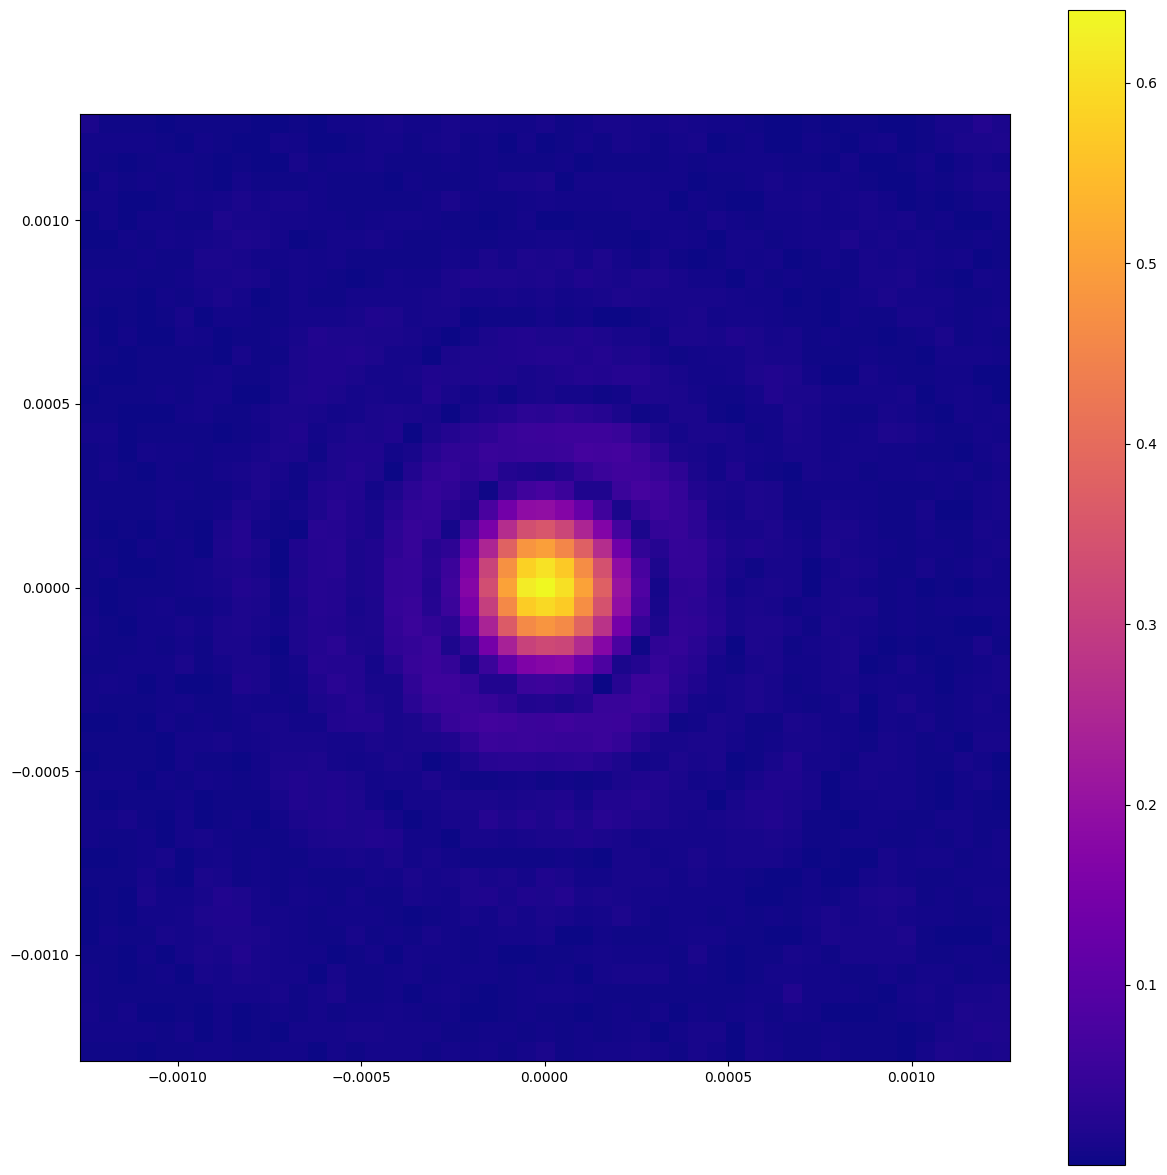

In [8]:
grid = ant_grid_data[3].GRID.values.mean(axis=0)[0, 0, ...]
l = ant_grid_data[3].l.values
m = ant_grid_data[3].m.values

fig, ax = plt.subplots()

beam = plt.imshow(np.abs(grid), extent=[l.min(), l.max(), m.min(), m.max()], cmap='plasma')
fig.colorbar(beam, ax=ax)

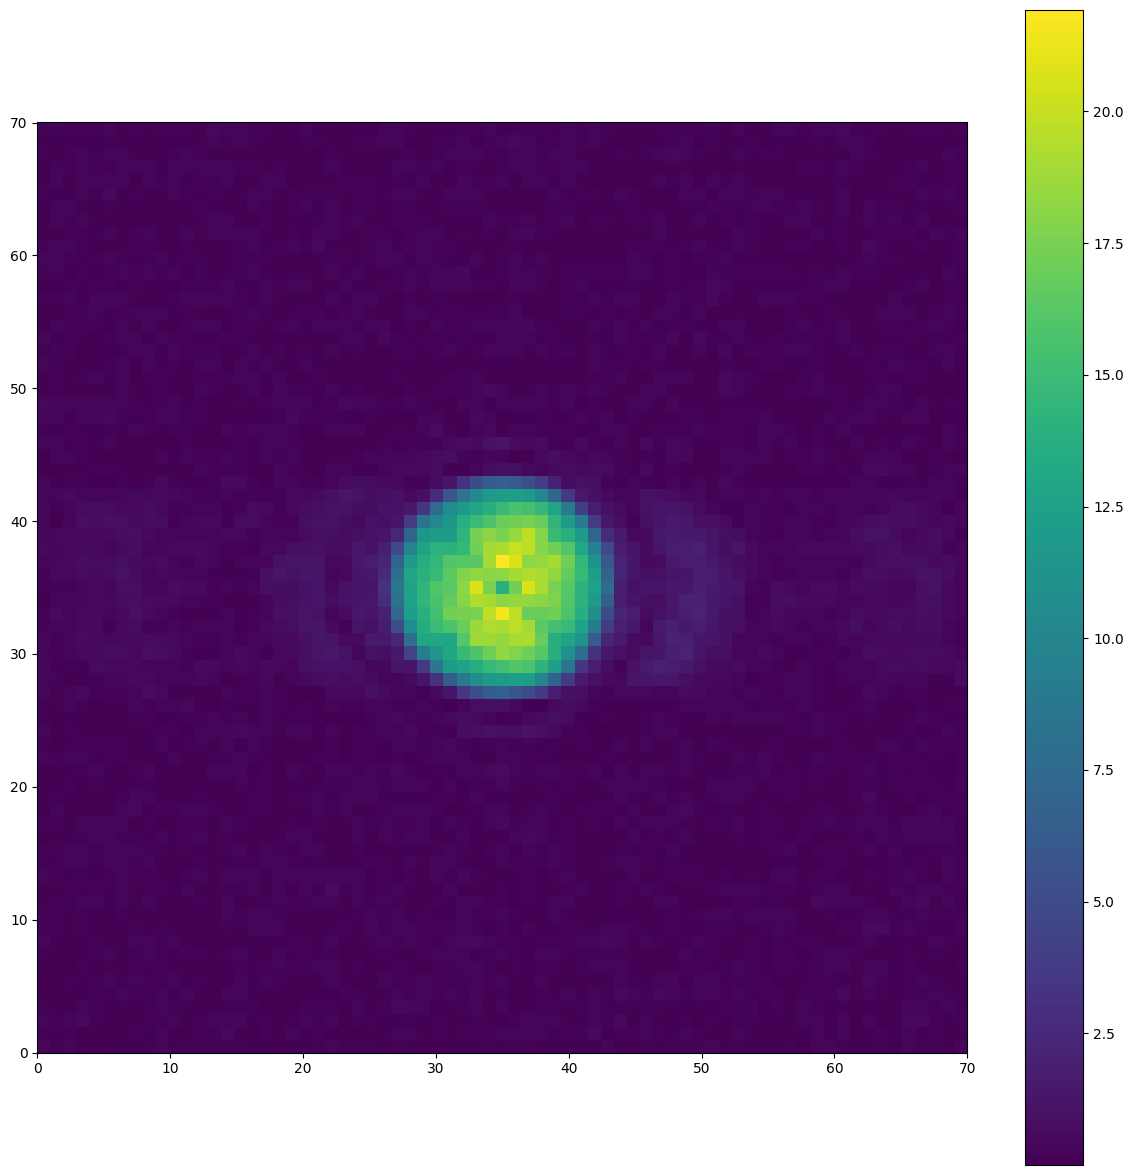

In [9]:
aperture = ant_grid_data[3].APERTURE.values.mean(axis=0)[0, 0, ...]
u = ant_grid_data[3].u.values
v = ant_grid_data[3].v.values

fig, ax = plt.subplots()

image = plt.imshow(np.abs(aperture), extent=[u.min(), u.max(), v.min(), v.max()])
fig.colorbar(image, ax=ax)

In [ ]:
import numpy as np
import scipy.fftpack

grid = np.random.random((2, 2, 2, 2, 2)) # scan, chan, pol, l, m
grid

In [ ]:
padding = 1
padded_grid = np.pad(array=grid, pad_width=[(0, 0), (0, 0), (0, 0), (padding, padding), (padding, padding)], mode='constant')
padded_grid